In [3]:
import torch 
import numpy as np
import pandas as pd
import transformers
import random
import json
import datasets
import html
from matplotlib import pyplot as plt

/home/samuel/.conda/envs/text/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer, BartForConditionalGeneration
import evaluate

In [39]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data preprocess

In [40]:
with open("./data/train.json","r") as f:
    data = f.readlines()

In [41]:
train_data = []
for d in data:
    try:
        train_data.append(eval(d))
    except Exception as e:
        print(d)

{"body":null,"title":"Prince William Just Followed in Mom Princess Diana's Footsteps with This Emotional Trip"}

{"body":null,"title":"The one part of life that means more than friends, pets, faith and jobs"}

{"body":null,"title":"This is LA's secret parking-lot pizza"}

{"body":null,"title":"Meet a cuddly baby dugong named Marium"}

{"body":null,"title":"Madonna - God Control (Official Music Video)"}

{"body":null,"title":"How to Make a Flip-Down Coat Rack"}

{"body":null,"title":"The best OTC pain reliever for every kind of ache"}

{"body":null,"title":"Nadal plays down row over Wimbledon seeding"}

{"body":null,"title":"2020 Jeep Gladiator Towing Test"}

{"body":null,"title":"Americans agree on one part of the U.S.-Russia relationship. But just one."}

{"body":null,"title":"How does the 2020 Jeep Gladiator stack up against the competition?"}

{"body":null,"title":"20 most commonly overlooked cancer symptoms"}

{"body":null,"title":"'I'm not ready to die': Paige Winter, teen that su

In [42]:
df = pd.DataFrame(train_data)
df['body'] = df['body'].str.encode('utf-8', 'replace').str.decode('utf-8')
df['title'] = df['title'].str.encode('utf-8', 'replace').str.decode('utf-8')

In [43]:
df['title_length'] = df['title'].apply(lambda x : len(x.split()))
df['body_length'] = df['body'].apply(lambda x : len(x.split()))

In [44]:
df

,body,title,title_length,body_length
0,"Only FIVE internationals allowed, count em, FI...",Predicting Atlanta United's lineup against Col...,12,509
1,WASHINGTON -- Senate Majority Leader Mitch McC...,Mitch McConnell: DC statehood push is 'full bo...,9,364
2,NORTH HIGHLANDS (CBS13) Fire damaged a home ...,Home In North Highlands Damaged By Fire,7,65
3,Meghan McCain is speaking out after a journali...,Meghan McCain blames 'liberal media' and 'thir...,16,28
4,"1714: George I becomes King Georg Ludwig, Elec...",Today in History: Aug 1,5,272
...,...,...,...,...
99948,CHICAGO (CBS) It's a battle that one south su...,Woman Fights To Prove Her Gender After Decades...,12,357
99949,Check out the news! Dak Prescott loves Amari C...,Cowboys news: Dak Prescott is on board with Am...,13,1179
99950,(Reuters) - Shares of Tesla Inc fell 1.7% on T...,Tesla faces delivery bottleneck at close of se...,9,325
99951,Cleveland is rolling out the red carpet as mor...,Jim Thome and Sandy Alomar Jr. named Grand Mar...,17,238


In [45]:
mask1 =(df['body_length']>10) & (df['body_length']<10000)
mask2 = df['body']!=df['title']
mask3 = (df['title_length']<df['body_length'])
df_filtered = df[mask2&mask1&mask3].reset_index(drop=True)

In [46]:
df_filtered[['body_length']].describe()

,body_length
count,96814.000000
mean,564.406935
std,660.858417
min,11.000000
25%,183.000000
50%,383.000000
75%,722.000000
max,9993.000000


<Axes: ylabel='Frequency'>

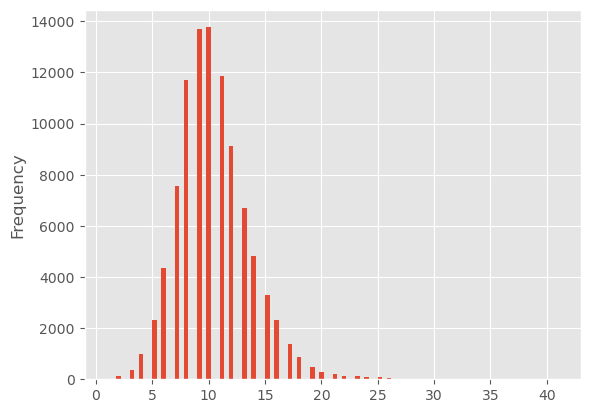

In [47]:
plt.style.use('ggplot')
df_filtered['title_length'].plot(kind="hist",bins=100)

In [48]:
df_filtered['body'] = df_filtered['body'].apply(lambda x: html.unescape(x))
df_filtered['title'] = df_filtered['title'].apply(lambda x: html.unescape(x))

In [49]:
df_filtered['body']

0        Only FIVE internationals allowed, count em, FI...
1        WASHINGTON -- Senate Majority Leader Mitch McC...
2        NORTH HIGHLANDS (CBS13)   Fire damaged a home ...
3        Meghan McCain is speaking out after a journali...
4        1714: George I becomes King Georg Ludwig, Elec...
                               ...                        
96809    CHICAGO (CBS)  It's a battle that one south su...
96810    Check out the news! Dak Prescott loves Amari C...
96811    (Reuters) - Shares of Tesla Inc fell 1.7% on T...
96812    Cleveland is rolling out the red carpet as mor...
96813    Charlotte Hornets GM Mitch Kupchak isn't doing...
Name: body, Length: 96814, dtype: object

In [55]:
dataset = datasets.Dataset.from_pandas(df_filtered)
all_dataset = dataset.train_test_split(train_size=0.8, seed=42)
all_dataset['val'] = all_dataset.pop('test')

In [56]:
all_dataset['val']

Dataset({
    features: ['body', 'title', 'title_length', 'body_length'],
    num_rows: 19363
})

In [57]:
def preprocess(data):
    model_inputs = tokenizer(data["body"],padding=True, max_length=1024,truncation=True, return_tensors='pt')

    labels = tokenizer(text_target=data["title"], padding=True, max_length=40, truncation=True, return_tensors='pt')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")                                     
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

In [59]:
all_dataset['train'] = all_dataset['train'].map(preprocess,batched=True,remove_columns=all_dataset['train'].column_names)
all_dataset['val'] = all_dataset['val'].map(preprocess,batched=True,remove_columns=all_dataset['val'].column_names)

In [60]:
len(all_dataset['train'] ),len(all_dataset['val'] )

(77451, 19363)

In [61]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,model ="facebook/bart-base" )

In [62]:
metric_rouge = evaluate.load("rouge", rouge_types=["rouge1", "rouge2", "rougeL"])
metric_bertscore = evaluate.load("bertscore")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_result = metric_rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bertscore_result = metric_bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    output = {k: round(v, 4) for k, v in rouge_result.items()}
    output["bertscore"] = np.mean(bertscore_result['precision'])
    output["gen_len"] = np.mean(prediction_lens)
    return output

In [63]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
training_args = Seq2SeqTrainingArguments(
    output_dir="version2_bart_30epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=10,
    num_train_epochs=30,
    predict_with_generate=True,
    fp16=True,
    save_strategy ="steps",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end =True,
    save_steps = 5000,
    logging_steps = 5000,
    eval_steps = 5000,
    eval_delay =500,
    logging_dir = 'logs',
    metric_for_best_model ="bertscore"
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=all_dataset['train'],
    eval_dataset=all_dataset['val'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/home/samuel/.conda/envs/text/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bertscore,Gen Len
2000,0.979000,0.853932,0.436500,0.260600,0.401600,0.401600,0.901183,15.701028
4000,0.943400,0.841035,0.449400,0.272700,0.414600,0.414600,0.903047,15.331767
6000,0.909300,0.812102,0.454200,0.276500,0.419300,0.419500,0.905989,15.072458
8000,0.909600,0.804749,0.455800,0.278800,0.421900,0.422000,0.907511,14.979342
10000,0.829000,0.809476,0.463200,0.284400,0.427600,0.427800,0.907411,15.241182


In [81]:
trainer.state.best_model_checkpoint

'version2_bart_30epoch/checkpoint-18000'

In [32]:
# model output
model = BartForConditionalGeneration.from_pretrained("version2_bart_30epoch/checkpoint-290000/")
inputs = tokenizer("Trailer 3", return_tensors="pt").input_ids
outputs  = model.generate(inputs, max_new_tokens=30, do_sample=False)
tokenizer.decode(outputs[0], skip_special_tokens=True)

'Trailer 3, 3- halftime camaraderie'

In [111]:
#label 
dataset[-10]['title']

'Pittsburgh-based company, Astrobotic awarded NASA contract to deliver moon rover'

In [ ]:
l = []
train_loss= {}
for obj in trainer.state.log_history:
    train_loss['loss'] =train_loss.get("loss",[])
    train_loss['step'] =train_loss.get("step",[])
    if "eval_loss" in obj.keys():
        l.append(obj)
    else:
        train_loss['loss'].append(obj['loss'])
        train_loss['step'].append(obj['step'])

In [ ]:
dic = {}
for d in l:
    for k,v in d.items():
        dic[k] = dic.get(k,[])
        dic[k].append(v)
df_eval = pd.DataFrame(dic)

<Axes: title={'center': 'train loss(per 1000 steps)'}>

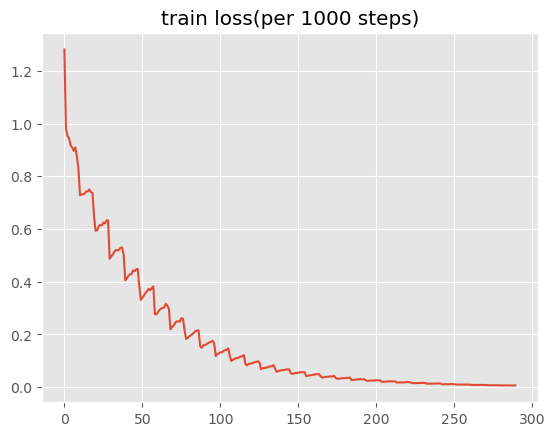

In [70]:
df_train = pd.DataFrame(train_loss)
loss = pd.concat([df_eval[['eval_loss']],df_train['loss']],axis=1)
loss.plot(title="train & validation loss(per 1000 steps)")

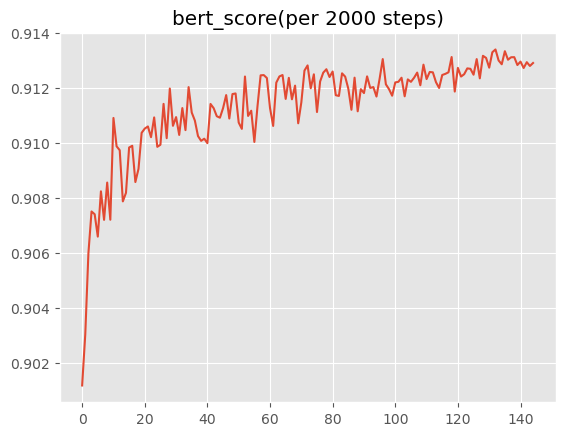

In [73]:
dic = {}
for d in l:
    for k,v in d.items():
        dic[k] = dic.get(k,[])
        dic[k].append(v)
df = pd.DataFrame(dic)
ax = df.loc[:,"eval_bertscore"].plot(title="bert_score(per 2000 steps)")

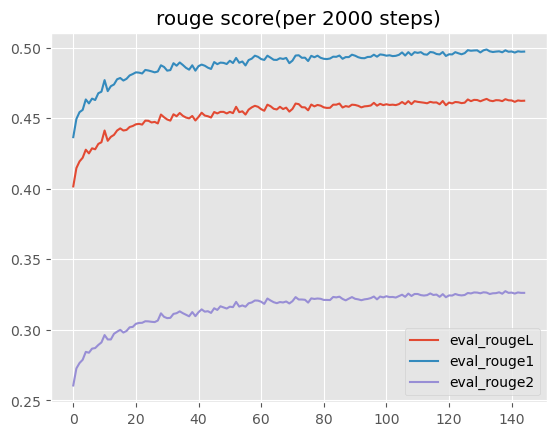

In [72]:
ax = df.loc[:,["eval_rougeL","eval_rouge1","eval_rouge2"]].plot(title="rouge score(per 2000 steps)")

In [1]:
from transformers import AutoTokenizer, BartForConditionalGeneration
from tqdm import tqdm
model_path="version2_bart_30epoch/checkpoint-290000/"
model = BartForConditionalGeneration.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

/home/samuel/.conda/envs/text/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
res = []
with open("data/test.json","r") as f:
    data = f.readlines()
    for d in tqdm(data[:-1]):
        try:
            d = eval(d)
            inputs = tokenizer(d['body'], return_tensors="pt",truncation=True).input_ids
            outputs  = model.generate(inputs, max_new_tokens=30, do_sample=False)
            outputs=tokenizer.decode(outputs[0], skip_special_tokens=True)
            # print(outputs)
            res.append({"title":outputs})
            print(outputs)
            break
        except Exception as e:
            res.append({"title":None})
            

13763


  0%|                                                             | 0/13763 [00:00<?, ?it/s]

Minnesota United to host FC Pachuca for international friendly


In [9]:
import json
with open("311707046.json", "w") as file:
    for item in res:
        json.dump(item, file)
        file.write('\n')

In [2]:
res=[]
with open("requirements.txt", "r") as f:
    data = f.readlines()
    for d in data:
        res.append(d.strip().split("@")[0])
with open("requirements.txt", "w") as f:  
    for r in res:
        f.write(r+"\n")